In [1]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam, SVDSGD
from src.callbacks import OrthogonalityTracker, ConditioningTracker, DecompositionTracker
from src.layers import SVDDense

In [3]:
plt.style.use('dark_background')

# MNIST performance benchmarking

### Data loading

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


### Visualization

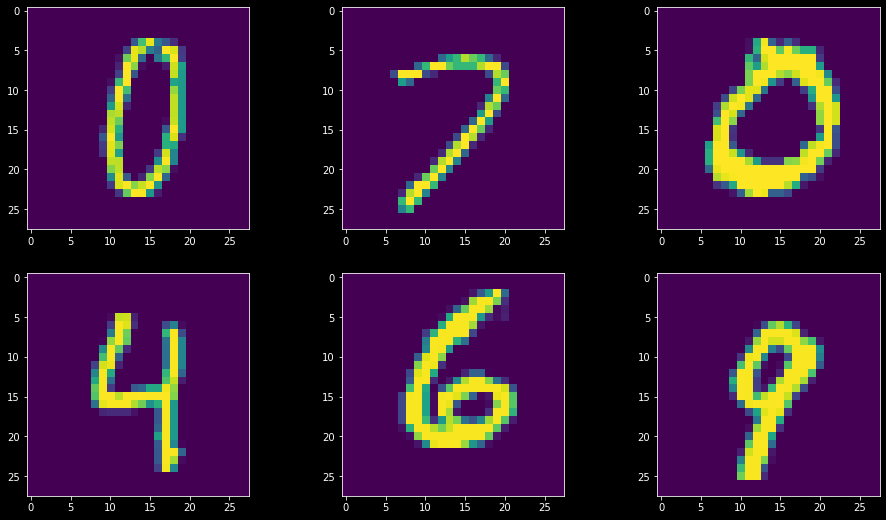

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.reshape(-1)
for ax in axes:
    ax.imshow(x_train[np.random.randint(len(x_train)), ...])
plt.show()

### Preprocessing

In [6]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

### Data pipeline

In [7]:
batch_size = 32
buffer_size = batch_size * 128
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(32, 28, 28, 1) (32,)


### Model

In [8]:
# Parameters for model architecture
units = 256
rank = 16
n_classes = 10
activation = 'elu'

In [9]:
def residual_block(inputs, filters=64, kernel_size=(1, 1)):
    # Batch norm
    outputs = tf.keras.layers.BatchNormalization()(inputs)
    # Pre-activation 
    outputs = tf.keras.activations.get(activation)(outputs)
    # Convolution
    outputs = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same')(outputs)
    # Batch norm
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    # Pre-activation 
    outputs = tf.keras.activations.get(activation)(outputs)
    # Convolution
    outputs = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, activation=activation, padding='same')(outputs)
    return tf.keras.layers.Add()([inputs, outputs])

In [11]:
def build_model(units, rank):
    # Make input layer
    inputs = tf.keras.Input(shape=x.shape[1:])
    # Convolutional layer
    hidden = tf.keras.layers.Conv2D(32, kernel_size=(7, 7), activation=activation)(inputs)
    # Maximum pooling
    hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
    # bottleneck
    hidden = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), activation=activation)(hidden)
    # Residual block
    hidden = residual_block(hidden, 64, (3, 3))
    # Residual block
    hidden = residual_block(hidden, 64, (3, 3))
    # Maximum pooling
    hidden = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(hidden)
    # bottleneck
    hidden = tf.keras.layers.Conv2D(256, kernel_size=(1, 1), activation=activation)(hidden)
    # Average pooling
    hidden = tf.keras.layers.GlobalAveragePooling2D()(hidden)
    # Flatten
    hidden = tf.keras.layers.Flatten()(hidden)
    # Fully connected
    if rank is None:
        hidden = tf.keras.layers.Dense(units, activation=activation)(hidden)
    else:
        hidden = SVDDense(units, rank, activation=activation)(hidden)
    # Dropout
    hidden = tf.keras.layers.Dropout(0.25)(hidden)
    # Projection layer
    outputs = tf.keras.layers.Dense(n_classes, 'softmax')(hidden)
    # Make & compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [300]:
# Number of epochs
epochs = 5
# Learning rates
learning_rate = 10e-5
nu = 10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

# Loss and accuracy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=2)
decomposition_tracker = DecompositionTracker(on_batch=True)

In [445]:
regular_model = build_model(units, None)
# SVD optimizer
optimizer = SVDAdam(regular_model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
regular_model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Early stopping
callbacks = [early_stopping , decomposition_tracker]
# Train model
regular_history = regular_model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 222s 117ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.8932 - val_loss: 0.1298 - val_sparse_categorical_accuracy: 0.9573
Epoch 2/5
1875/1875 [==============================] - 219s 117ms/step - loss: 0.0856 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.0670 - val_sparse_categorical_accuracy: 0.9786
Epoch 3/5
1875/1875 [==============================] - 219s 117ms/step - loss: 0.0582 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0474 - val_sparse_categorical_accuracy: 0.9852
Epoch 4/5
1875/1875 [==============================] - 219s 117ms/step - loss: 0.0438 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0479 - val_sparse_categorical_accuracy: 0.9845
Epoch 5/5
1875/1875 [==============================] - 219s 117ms/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9874


In [16]:
# Make trackers
orthogonality_tracker = OrthogonalityTracker(on_batch=True)
conditioning_tracker = ConditioningTracker(on_batch=True)

In [17]:
model = build_model(units, rank)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Callbacks
callbacks = [early_stopping]
# Add trackers to callbacks
callbacks += [orthogonality_tracker, conditioning_tracker]
# Train model
history_ = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/5
1875/1875 [==============================] - 169s 88ms/step - loss: 0.8017 - sparse_categorical_accuracy: 0.8575 - val_loss: 0.0931 - val_sparse_categorical_accuracy: 0.9724
Epoch 2/5
1875/1875 [==============================] - 166s 88ms/step - loss: 0.1076 - sparse_categorical_accuracy: 0.9690 - val_loss: 0.0665 - val_sparse_categorical_accuracy: 0.9796
Epoch 3/5
1875/1875 [==============================] - 165s 88ms/step - loss: 0.0713 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0508 - val_sparse_categorical_accuracy: 0.9834
Epoch 4/5
1875/1875 [==============================] - 165s 88ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0446 - val_sparse_categorical_accuracy: 0.9852
Epoch 5/5
1875/1875 [==============================] - 164s 88ms/step - loss: 0.0432 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.0465 - val_sparse_categorical_accuracy: 0.9847


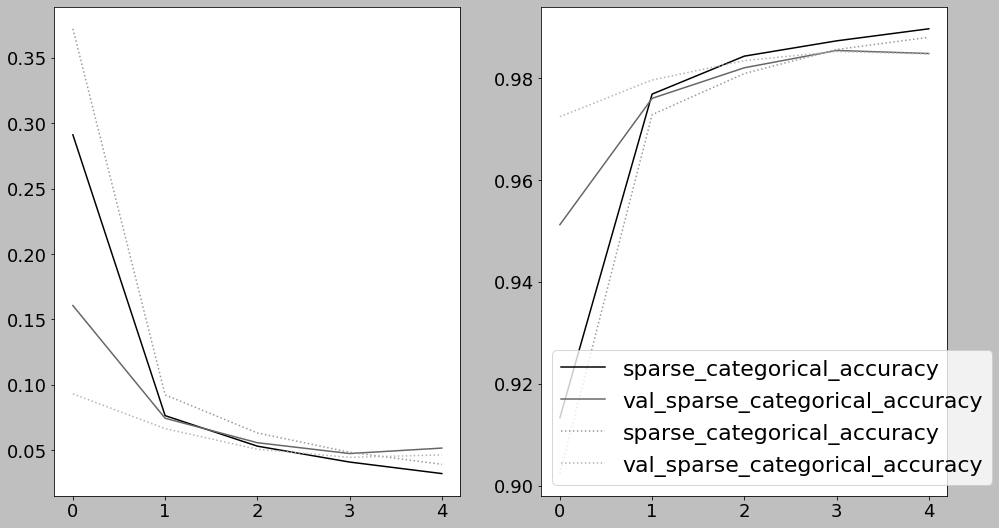

In [276]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for key, value in regular_history.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key)
for key, value in history_.history.items():
    i = 0 if 'loss' in key else 1
    axes[i].plot(value, label=key, linestyle='dotted')
plt.legend()
plt.show()

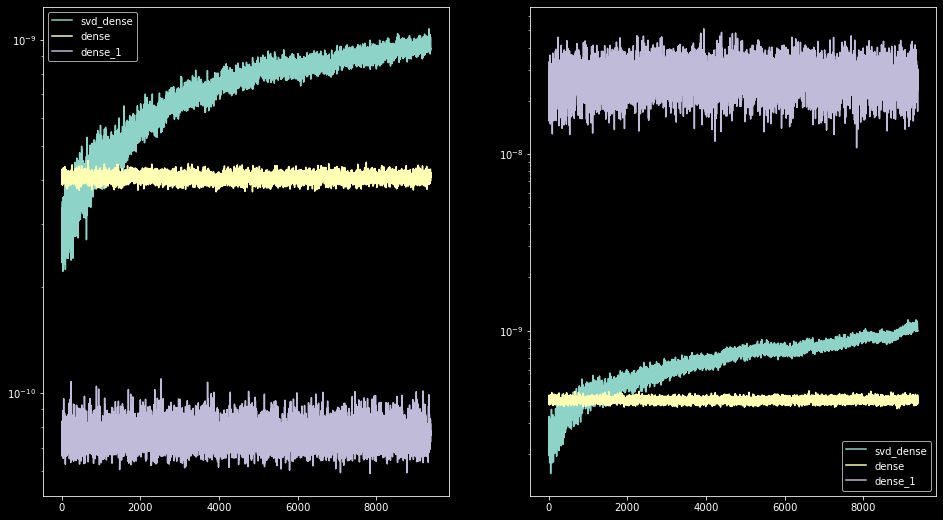

In [19]:
fig, axes = plt.subplots(1,2, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        axes[0].plot(orthogonality_tracker.kappa[layer.name]['u'], label=layer.name)
        axes[1].plot(orthogonality_tracker.kappa[layer.name]['v'], label=layer.name)
for layer, values in decomposition_tracker.kappa.items():
    axes[0].plot(values['u'], label=layer)
    axes[1].plot(values['v'], label=layer)
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].legend()
axes[1].legend()
plt.show()

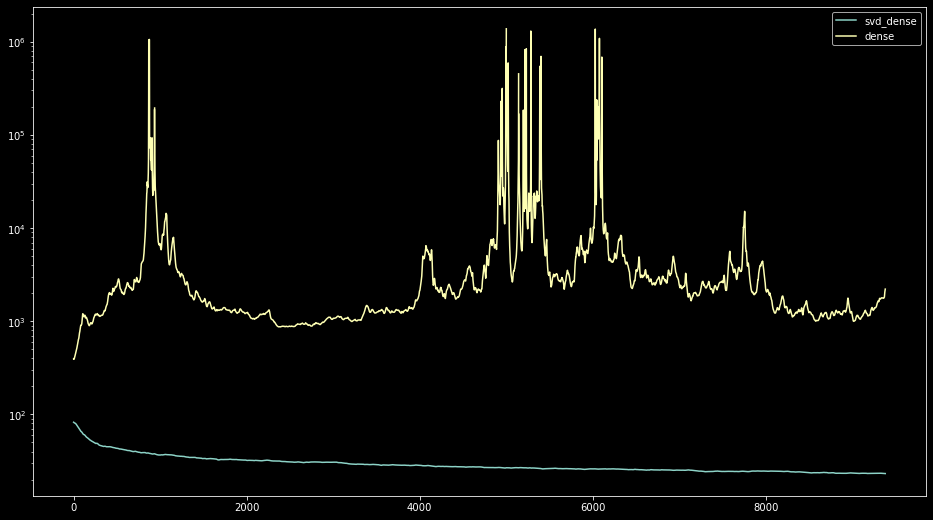

In [20]:
fig, axes = plt.subplots(1,1, figsize=(16, 9))
for layer in model.layers:
    if 'svd' in layer.name:
        plt.plot(conditioning_tracker.kappa[layer.name], label=layer.name)
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(values['s'], label=layer)
    break
plt.yscale('log')
plt.legend()
plt.show()

### Rank dependence

In [21]:
# empty dicts for models & histories
models_rank = {}
histories_rank = {}
trackers_rank = {}

In [22]:
# Train model
histories_rank[rank] = history_
models_rank[rank] = model
trackers_rank[rank] = callbacks

In [134]:
ranks = [62, 128]

for rank in ranks:
    # Make trackers
    orthogonality_tracker = OrthogonalityTracker(on_batch=True)
    conditioning_tracker = ConditioningTracker(on_batch=True)
    # Make model
    model = build_model(units, rank)
    # SVD optimizer
    optimizer = SVDAdam(model, learning_rate, nu, beta, gamma)
    # Compile model
    model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
    # Callbacks
    callbacks = [early_stopping]
    # Add trackers to callbacks
    callbacks += [orthogonality_tracker, conditioning_tracker]
    # Train model
    histories_rank[rank] = model.fit(dataset, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
    models_rank[rank] = model
    trackers_rank[rank] = callbacks

Epoch 1/5
1875/1875 [==============================] - 167s 87ms/step - loss: 0.6967 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.1072 - val_sparse_categorical_accuracy: 0.9680
Epoch 2/5
1875/1875 [==============================] - 163s 87ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.0644 - val_sparse_categorical_accuracy: 0.9806
Epoch 3/5
1875/1875 [==============================] - 163s 87ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0475 - val_sparse_categorical_accuracy: 0.9845
Epoch 4/5
1875/1875 [==============================] - 163s 87ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.0390 - val_sparse_categorical_accuracy: 0.9872
Epoch 5/5
1875/1875 [==============================] - 163s 87ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0352 - val_sparse_categorical_accuracy: 0.9886
Epoch 1/5
1875/1875 [==============================] - 180s 94ms/step - loss: 0.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
plt.style.use('grayscale')
params = {'legend.fontsize': '22',
          'figure.figsize': (16, 9),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18'}
plt.rcParams.update(params)

<ipython-input-20-e47cd360739f>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


IndexError: list index out of range

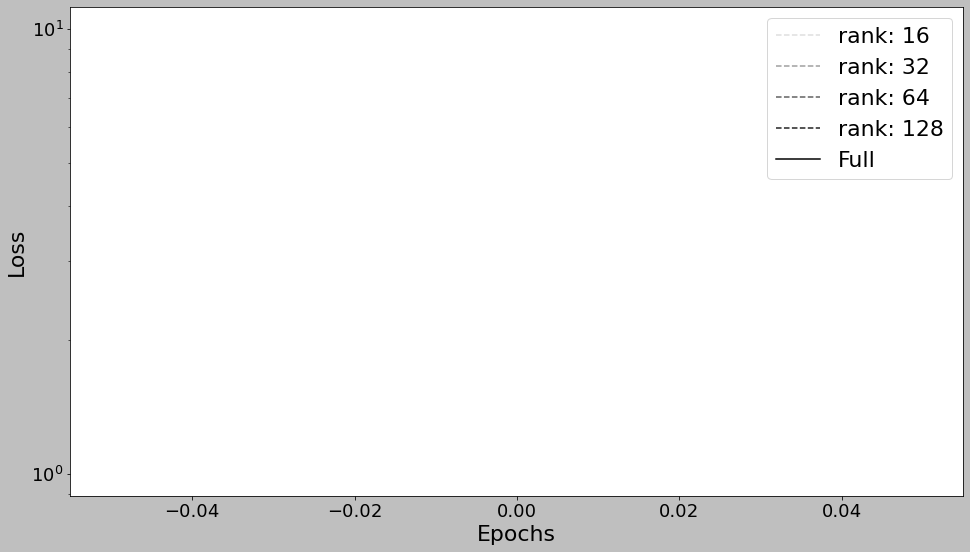

In [20]:
plt.figure(figsize=(16, 9))
for rank in [16, 32, 64, 128]:    
    plt.plot(0, label=f'rank: {rank}', linestyle='dashed', color=str((7.5 - np.log2(rank))/4))
    plt.plot(0, linestyle='dashed', marker='>', color=str((7.5 - np.log2(rank))/4))
plt.plot(0, label=f'Full', color='black')
plt.plot(0, marker='>', color='black')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
lines = plt.legend().get_lines()
legend1 = plt.legend([lines[0], lines[-6]], ['Train', 'Test'], loc=2)
plt.gca().add_artist(legend1)
plt.legend()
plt.savefig('figures/MNIST_loss_legend.png')
plt.show()

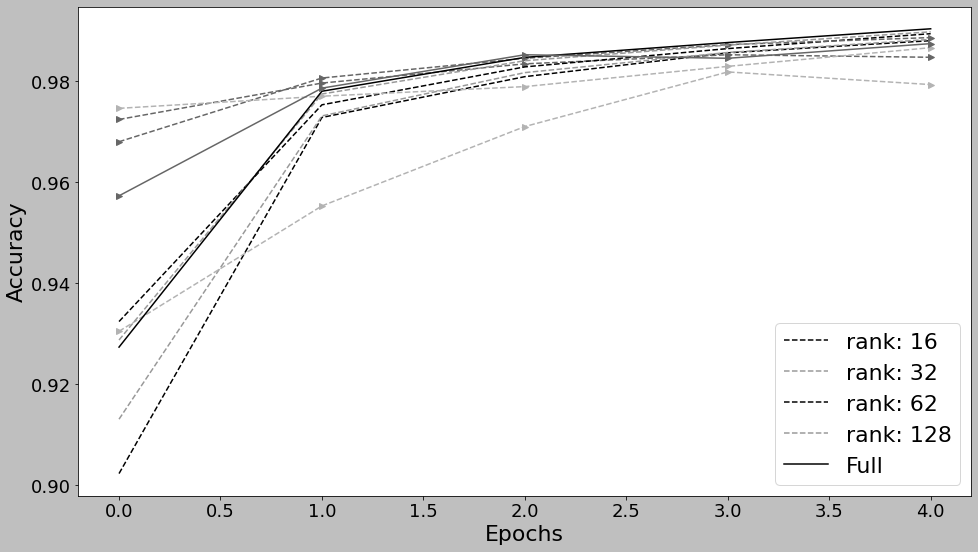

In [485]:
plt.figure(figsize=(16, 9))
for rank, history in histories_rank.items():
    plt.plot(history.history['sparse_categorical_accuracy'], label=f'rank: {rank}', linestyle='dashed')
    plt.plot(history.history['val_sparse_categorical_accuracy'], marker='>', linestyle='dashed')
plt.plot(regular_history.history['sparse_categorical_accuracy'], label=f'Full')
plt.plot(regular_history.history['val_sparse_categorical_accuracy'], marker='>')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('figures/MNIST_accuracy.png')
plt.show()

In [486]:
N = 250

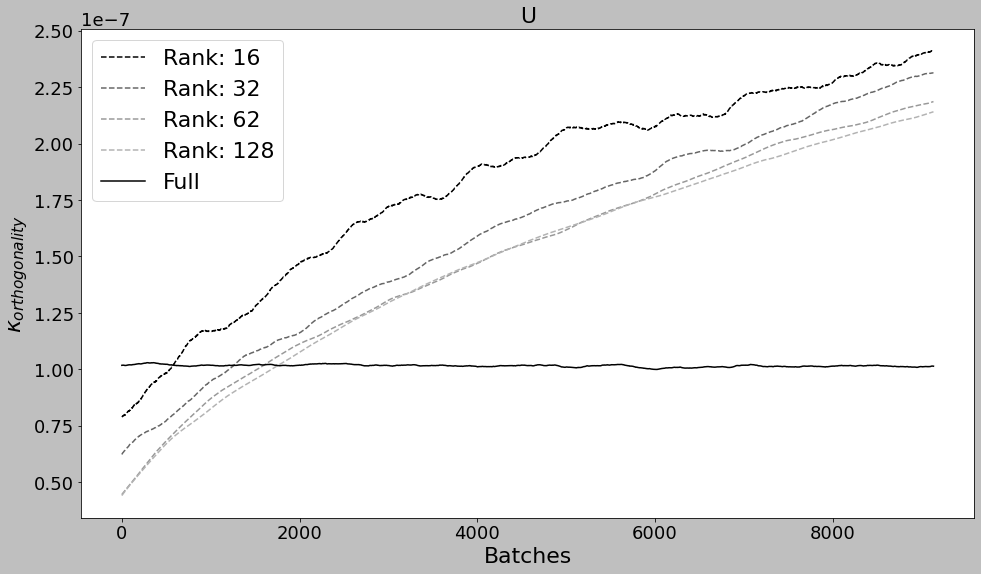

In [487]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    ortho = track[1].kappa
    values = ortho[list(ortho.keys())[0]]['u']
    plt.plot(np.convolve(values, np.ones(N), mode='valid'), label=f'Rank: {rank}', linestyle='dashed')
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(np.convolve(values['u'], np.ones(N), mode='valid'), label=f'Full', color='black')
    break

plt.title('U')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{orthogonality}$')
plt.legend()
plt.savefig('figures/MNIST_orthogonality_u.png')
plt.show()

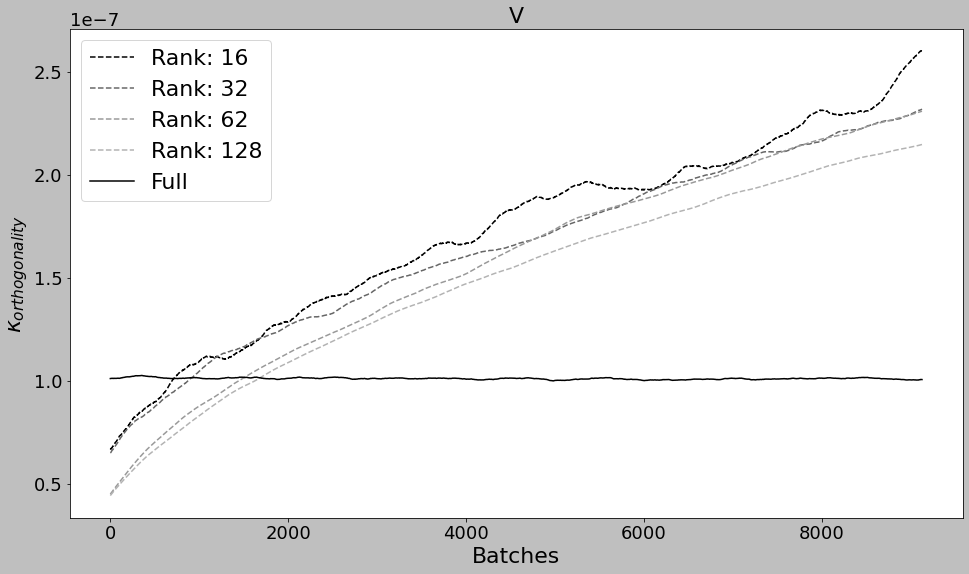

In [488]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    ortho = track[1].kappa
    values = ortho[list(ortho.keys())[0]]['v']
    plt.plot(np.convolve(values, np.ones(N), mode='valid'), label=f'Rank: {rank}', linestyle='dashed')
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(np.convolve(values['v'], np.ones(N), mode='valid'), label=f'Full', color='black')
    break
    
plt.title('V')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{orthogonality}$')
plt.legend()
plt.savefig('figures/MNIST_orthogonality_v.png')
plt.show()

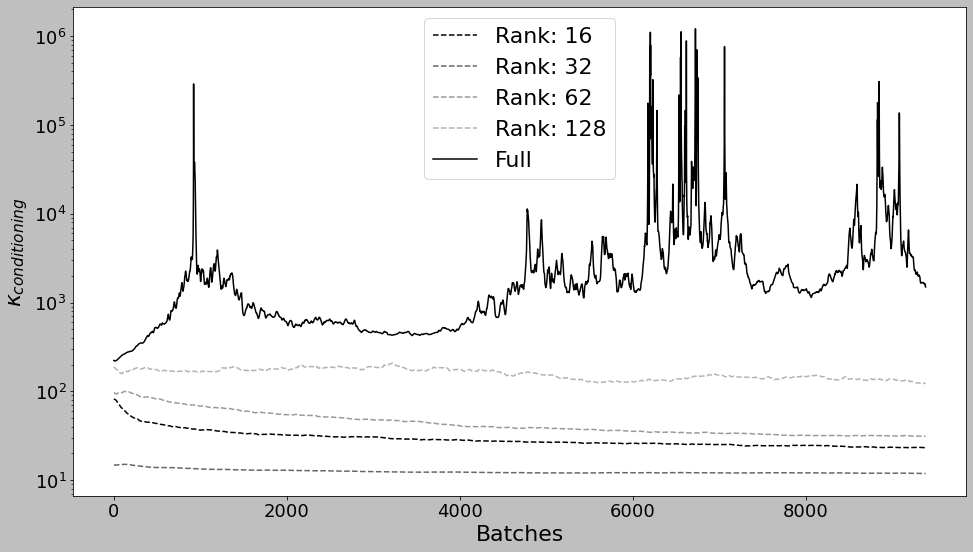

In [489]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    cond = track[2].kappa
    plt.plot(cond[list(cond.keys())[0]], label=f'Rank: {rank}', linestyle='dashed')
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(values['s'], label='Full', color='black')
    break
plt.yscale('log')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{conditioning}$')
plt.legend()
plt.savefig('figures/MNIST_conditioning.png')
plt.show()

In [186]:
for model in list(models_rank.values()):
    print(np.mean(y_train == np.argmax(model(x_train), axis=-1)))

0.9868833333333333
0.9804166666666667
0.9916833333333334
0.9887666666666667


In [452]:
print(np.mean(y_train == np.argmax(regular_model(x_train), axis=-1)))

0.9904833333333334


In [189]:
for model in list(models_rank.values()):
    print(np.mean(y_test == np.argmax(model(x_test), axis=-1)))

0.9847
0.9793
0.9886
0.9866


In [453]:
print(np.mean(y_test == np.argmax(regular_model(x_test), axis=-1)))




0.9874
